# Actividad 6
____________________

- Jose Israel Perez Ontiveros | A01423294
- Maximiliano Romero Budib | 
- Ruben Vazquez


## Descripcion

añadir

## 1. Importar librerias

In [68]:
#Instalamos la librería para análisis de variables categóricas
%pip install funpymodeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from funpymodeling.exploratory import freq_tbl

Note: you may need to restart the kernel to use updated packages.


## 2. Cargar Archivo

In [69]:
data = pd.read_csv("./Recursos/TrainingDataComplete.csv", index_col=0)
display(data)

,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
Id,,,,,,,,,,,,
1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
251996,8154883,43,13,single,rented,no,Surgeon,Kolkata,West_Bengal,6,11,0
251997,2843572,26,10,single,rented,no,Army_officer,Rewa,Madhya_Pradesh,6,11,0
251998,4522448,46,7,single,rented,no,Design_Engineer,Kalyan-Dombivli,Maharashtra,7,12,0


## 3. Preprocesamiento (Nulos y Outliers)

- 3.1 Verificamos info del DF

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252000 entries, 1 to 252000
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Income             252000 non-null  int64 
 1   Age                252000 non-null  int64 
 2   Experience         252000 non-null  int64 
 3   Married/Single     252000 non-null  object
 4   House_Ownership    252000 non-null  object
 5   Car_Ownership      252000 non-null  object
 6   Profession         252000 non-null  object
 7   CITY               252000 non-null  object
 8   STATE              252000 non-null  object
 9   CURRENT_JOB_YRS    252000 non-null  int64 
 10  CURRENT_HOUSE_YRS  252000 non-null  int64 
 11  Risk_Flag          252000 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 25.0+ MB


In [71]:
# Separamos columnas cuantitativas y cualitativas
dataCualitativas  = data.iloc[: , [3, 4, 5, 6, 7, 8, 11]]
dataCuantitativas = data.iloc[: , [0, 1, 2, 9, 10]]

print(f'Columnas cualitativas: {dataCualitativas.columns}')
print(f'\n\nColumnas cuantitativas: {dataCuantitativas.columns}')

Columnas cualitativas: Index(['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession',
       'CITY', 'STATE', 'Risk_Flag'],
      dtype='object')


Columnas cuantitativas: Index(['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS'], dtype='object')


In [72]:
# Verificamos que no hayan valores nulos
valores_nulos = dataCuantitativas.isnull().sum()
print(valores_nulos)

Income               0
Age                  0
Experience           0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
dtype: int64


Al no encontrar valores nulos podemos avanzar a la identificación de outliers

- 3.2 Diagrama de bigote

<Figure size 1500x800 with 0 Axes>

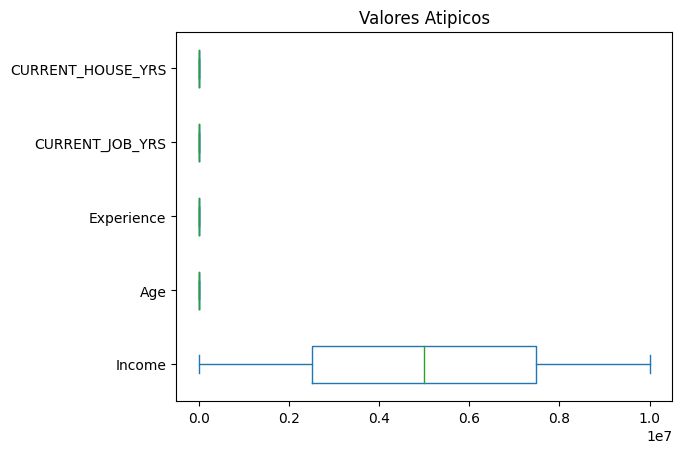

In [73]:
fig = plt.figure(figsize = (15, 8))
dataCuantitativas.plot(kind='box', vert=False)
plt.title('Valores Atipicos')
plt.show()

- 3.3 Metodo de cuantiles

In [74]:
# Encontramos los valores extremos
y = dataCuantitativas

percentile25 = y.quantile(0.25) #Q1
percentile75 = y.quantile(0.75) #Q3

iqr = percentile75 - percentile25

limiteSuperiorIQR = percentile75 + 1.5 * iqr
limiteInferiorIQR = percentile25 - 1.5 * iqr


print(f"Limite superior permitido :")
for col, val in limiteSuperiorIQR.items():
    print(f"{col}: {round(val, 2)}")

print(f"\n\nLimite inferior permitido :")
for col, val in limiteInferiorIQR.items():
    print(f"{col}: {round(val, 2)}")

Limite superior permitido :
Income: 14939232.5
Age: 110.0
Experience: 30.0
CURRENT_JOB_YRS: 18.0
CURRENT_HOUSE_YRS: 16.0


Limite inferior permitido :
Income: -4958715.5
Age: -10.0
Experience: -10.0
CURRENT_JOB_YRS: -6.0
CURRENT_HOUSE_YRS: 8.0


In [75]:
# Encontramos Outliers
outliers = dataCuantitativas[(y>limiteSuperiorIQR) | (y<limiteInferiorIQR)]
print(f"\nOutliers:\n")
for col, val in outliers.items():
    print(f"{col}: {round(val, 2)}")


Outliers:

Income: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: Income, Length: 252000, dtype: float64
Age: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: Age, Length: 252000, dtype: float64
Experience: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: Experience, Length: 252000, dtype: float64
CURRENT_JOB_YRS: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: CURRENT_JOB_YRS, Length: 252000, dtype: float64
CURRENT_HOUSE_YRS: Id
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
          ..
251996   NaN
251997   NaN
251998   NaN
251999   NaN
252000   NaN
Name: C

- 3.4 Convertir outliers en nulos

In [76]:
dataIqr = dataCuantitativas[(y<=limiteSuperiorIQR) & (y>=limiteInferiorIQR)]
display(dataIqr)

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Id,,,,,
1,1303834,23,3,3,13
2,7574516,40,10,9,13
3,3991815,66,4,4,10
4,6256451,41,2,2,12
5,5768871,47,11,3,14
...,...,...,...,...,...
251996,8154883,43,13,6,11
251997,2843572,26,10,6,11
251998,4522448,46,7,7,12


In [77]:
# Corroboramos valores nulos
valores_nulos = dataIqr.isnull().sum()
print(valores_nulos)

Income               0
Age                  0
Experience           0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
dtype: int64


Nota. Al no encontrar valores nulos podemos inferir que no existen valores atipicos y nuestros datos se encuentran limpios.

- 3.5 Unimos las columnas cuantitativas con las cualitativas

In [78]:
dataClean = pd.concat([dataCualitativas, dataIqr], axis=1)
display(dataClean)

,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,Risk_Flag,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS
Id,,,,,,,,,,,,
1,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,0,1303834,23,3,3,13
2,single,rented,no,Software_Developer,Parbhani,Maharashtra,0,7574516,40,10,9,13
3,married,rented,no,Technical_writer,Alappuzha,Kerala,0,3991815,66,4,4,10
4,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,1,6256451,41,2,2,12
5,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,1,5768871,47,11,3,14
...,...,...,...,...,...,...,...,...,...,...,...,...
251996,single,rented,no,Surgeon,Kolkata,West_Bengal,0,8154883,43,13,6,11
251997,single,rented,no,Army_officer,Rewa,Madhya_Pradesh,0,2843572,26,10,6,11
251998,single,rented,no,Design_Engineer,Kalyan-Dombivli,Maharashtra,0,4522448,46,7,7,12


## 4. Extraccion de caracteristicas

Dentro de este proceso se busca extraer caracteristicas relevantes de los datos presentes en cada una de las columnas de nuestro DF.

- 4.1 Columna Age

Como se observa en la gráfica de barras, en los datos encontramos un rango amplio de edades que va desde 21 - 79 años de edad. De misma forma, realizamos un analisis para ver si la edad es factor para definir si una personas se encuentra en estado de riesgo o no (como se muestra en la gráfica de pastel), sin embargo, vemos que de igual manera, hay variedad en edades, por lo que no podriamos decir que la edad es un factor

Text(0, 0.5, 'Personas')

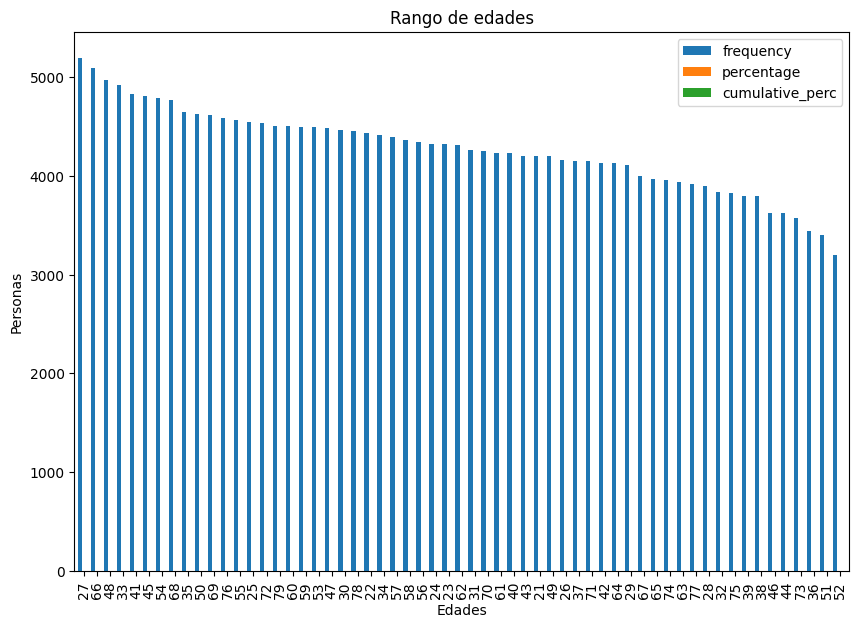

In [117]:
table = freq_tbl(dataClean['Age'].astype("string"))
Filtro = table[table['frequency']>9]
Filtro_setter = Filtro.set_index("Age")
Filtro_setter
Filtro_setter.plot(kind = "bar" , width=1, figsize=(10,7))
plt.title('Rango de edades')
plt.xlabel('Edades')
plt.ylabel('Personas')

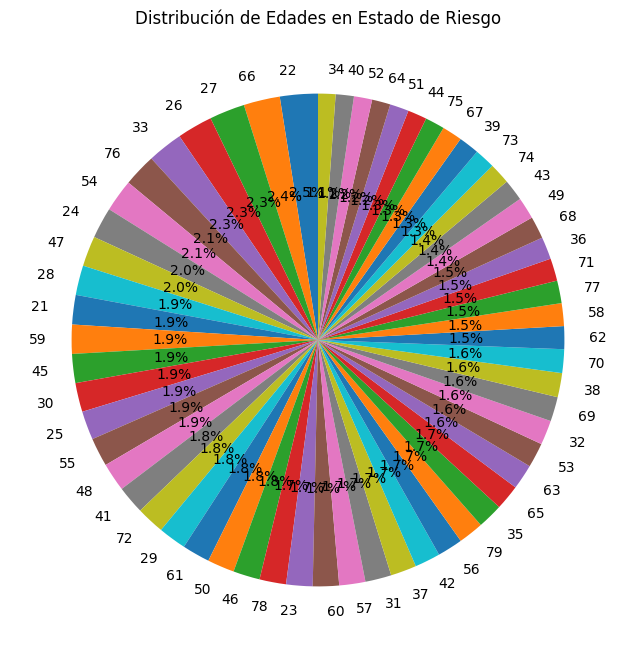

In [116]:
filtro = dataClean[dataClean['Risk_Flag'] == 1]

edadesRiesgo = filtro['Age'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(edadesRiesgo, labels=edadesRiesgo.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Edades en Estado de Riesgo')
plt.show()

- 4.2 Columna Experience

Como se muestra en la gráfica de barras, encontramos en los datos a gente inexperta como experta en su área y va de 0 - 20 años de experiencia

Text(0, 0.5, 'Personas')

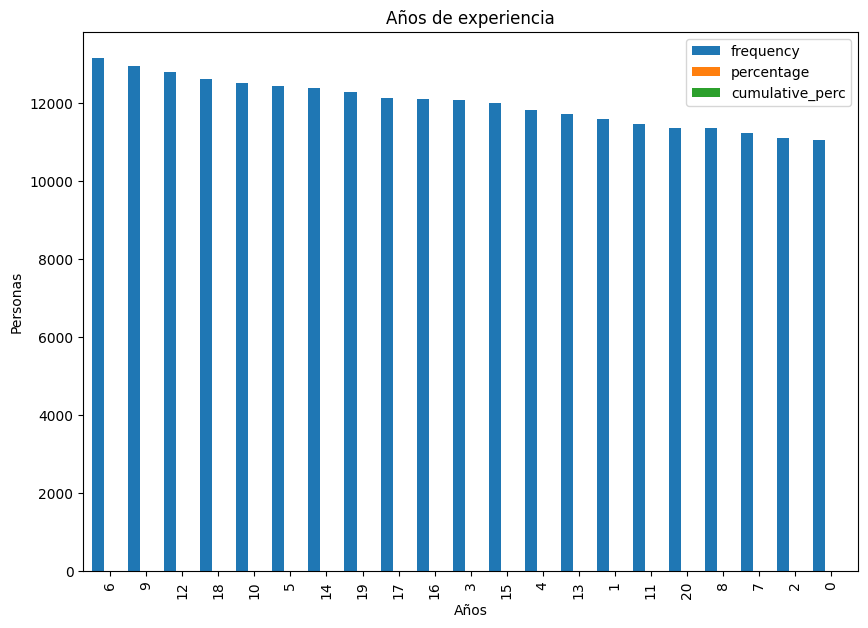

In [80]:
table = freq_tbl(dataClean['Experience'].astype("string"))
Filtro = table[table['frequency']>9]
Filtro_setter = Filtro.set_index("Experience")
Filtro_setter
Filtro_setter.plot(kind = "bar" , width=1, figsize=(10,7))
plt.title('Años de experiencia')
plt.xlabel('Años')
plt.ylabel('Personas')

- 4.3 Columna Married/Single

Como se muestra en la gráfica de pastel, vemos que la mayor parte de la población se encuentra soltera (89.8%), mientras que solo el 10.2% se encuentra casada. Por tanto, hay 226,272 personas solteras y 25,728 personas casadas.

,Married/Single,frequency,percentage,cumulative_perc
0,single,226272,0.897905,0.897905
1,married,25728,0.102095,1.000000


Personas solteras: 226272
Personas casadas: 25728


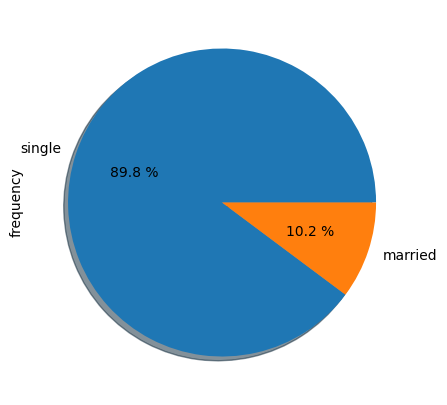

In [91]:
table = freq_tbl(dataClean['Married/Single'])
display(table)
Filtro = table[table['frequency'] > 1]
Filtro_setter = Filtro.set_index("Married/Single")
Filtro_setter

Filtro_setter["frequency"].plot(kind="pie", figsize=(10,5), shadow=True, autopct="%0.1f %%")

print(f"Personas solteras: {Filtro['frequency'][0]}")
print(f"Personas casadas: {Filtro['frequency'][1]}")


- 4.4 Columna House_Ownership

Como se muestra en la gráfica de pastel la mayor parte de la población renta, siendo el 92% de la poblacion (231,898 personas), mientras que solo el 5.1% de la población es dueña de algun espacio (12,918 personas) y el resto no renta ni es dueña de alguna propiedad (7184 personas)

Personas rentando: 231898
Personas con propiedad: 12918
Personas sin propiedad ni renta: 7184


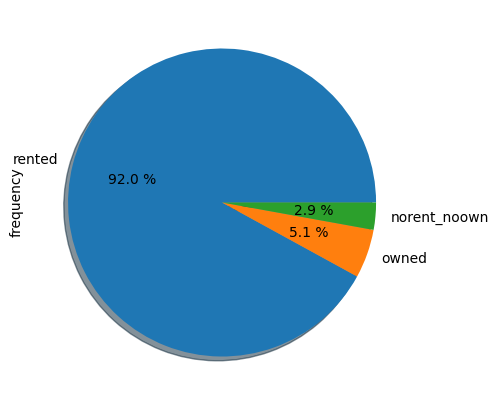

In [93]:
table = freq_tbl(dataClean['House_Ownership'])
Filtro = table[table['frequency'] > 20]
Filtro_setter = Filtro.set_index("House_Ownership")
Filtro_setter

Filtro_setter["frequency"].plot(kind="pie", figsize=(10,5), shadow=True, autopct="%0.1f %%")

cantidadRegistros = dataClean.shape[0]

print(f"Personas rentando: {Filtro['frequency'][0]}")
print(f"Personas con propiedad: {Filtro['frequency'][1]}")
print(f"Personas sin propiedad ni renta: {Filtro['frequency'][2]}")


- 4.5 Columna Profession

Como se muestra en la gráfica de barras contamos con 51 tipos de profesiones distintas así como de áreas distintas

Profesiones distintas: 51


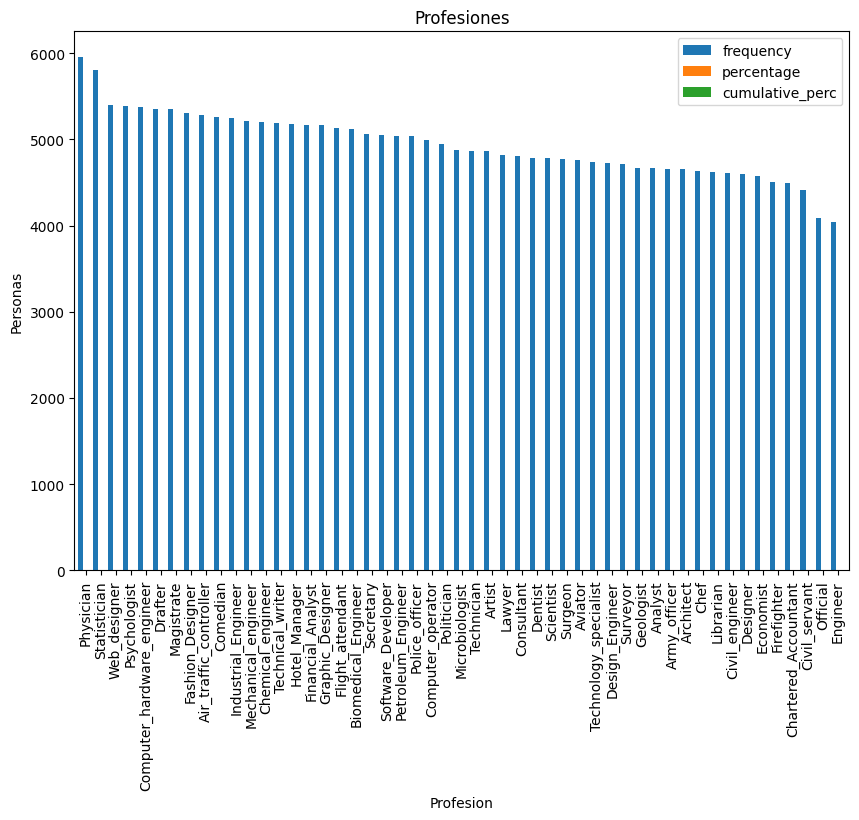

In [97]:
table = freq_tbl(dataClean['Profession'])
Filtro = table[table['frequency']>9]
Filtro_setter = Filtro.set_index("Profession")
Filtro_setter
Filtro_setter.plot(kind = "bar" , width=1, figsize=(10,7))
plt.title('Profesiones')
plt.xlabel('Profesion')
plt.ylabel('Personas')

print(f'Profesiones distintas: {table["Profession"].shape[0]}')

- 4.6 Columna CITY

En un analisis previo podemos confirmar que existen 317 ciudades distintas, por lo que desplegarlas en una misma tabla pueda a llegar a ser confuso por la contener demasiada información en un espacio reducido. Por tanto, se decidió mostrar unicamente las 20 ciudades más populares dentro del DF, siendo Vijayanaram la ciudad más popular entre los datos.

Ciudades distintas: 317


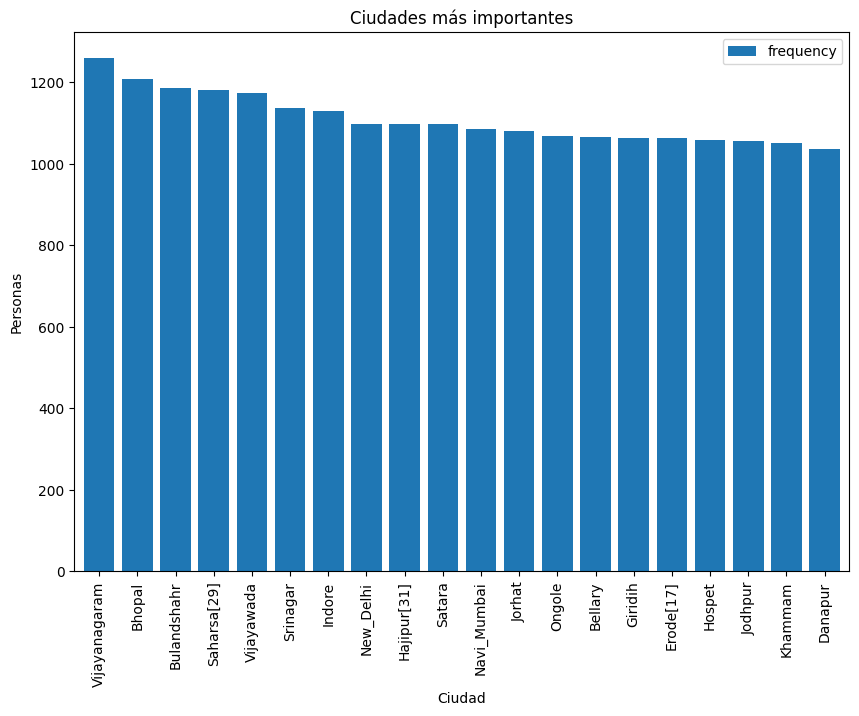

In [98]:
table = freq_tbl(dataClean['CITY'])
Filtro = table.sort_values(by='frequency', ascending=False).head(20)

Filtro.plot(kind="bar", x="CITY", y="frequency", width=0.8, figsize=(10, 7))
plt.title('Ciudades más importantes')
plt.xlabel('Ciudad')
plt.ylabel('Personas')

print(f'Ciudades distintas: {table["CITY"].shape[0]}')

- 4.7 Columna CURRENT_JOB_YRS

Como se muestra en la gráfica de barras, encontramos en los datos gente empezando en una empresa nueva así como veteranos dentro de una empresa, los años van de 0 - 14

Text(0, 0.5, 'Personas')

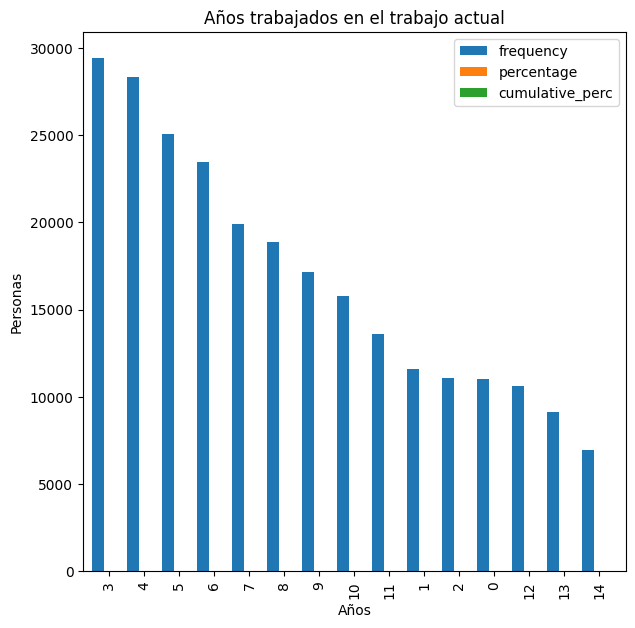

In [107]:
table = freq_tbl(dataClean['CURRENT_JOB_YRS'].astype("string"))
Filtro = table[table['frequency']>9]
Filtro_setter = Filtro.set_index("CURRENT_JOB_YRS")
Filtro_setter
Filtro_setter.plot(kind = "bar" , width=1, figsize=(7,7))
plt.title('Años trabajados en el trabajo actual')
plt.xlabel('Años')
plt.ylabel('Personas')

- 4.8 Columna CURRENT_HOUSE_YRS

Como se muestra en la gráfica de pastel todas las personas dentro de los datos proporcionados llevan un minimo de 10 años dentro de una misma residencia y hasta con 14 años habitando el mismo lugar.

,CURRENT_HOUSE_YRS,frequency,percentage,cumulative_perc
0,11,51873,0.205845,0.205845
1,12,51791,0.20552,0.411365
2,13,50659,0.201028,0.612393
3,14,49003,0.194456,0.806849
4,10,48674,0.193151,1.0


<Axes: ylabel='frequency'>

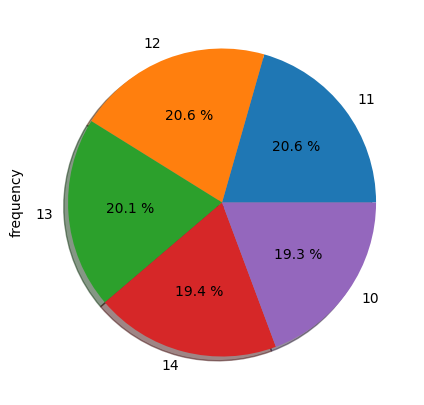

In [86]:
table = freq_tbl(dataClean['CURRENT_HOUSE_YRS'].astype("string"))
display(table)
Filtro = table[table['frequency'] > 20]
Filtro_setter = Filtro.set_index("CURRENT_HOUSE_YRS")
Filtro_setter

Filtro_setter["frequency"].plot(kind="pie", figsize=(10,5), shadow=True, autopct="%0.1f %%")


- 4.9 Columna Risk_Flag

Como se muestra en la gráfica de pastel, el 87.7% de la población no se encuentra en satus de riesgo (221,004 personas), mientras que el 12.3% lo está (30,996 personas)

,Risk_Flag,frequency,percentage,cumulative_perc
0,0,221004,0.877,0.877
1,1,30996,0.123,1.0


Personas sin riesgo: 221004
Personas en riesgo: 30996


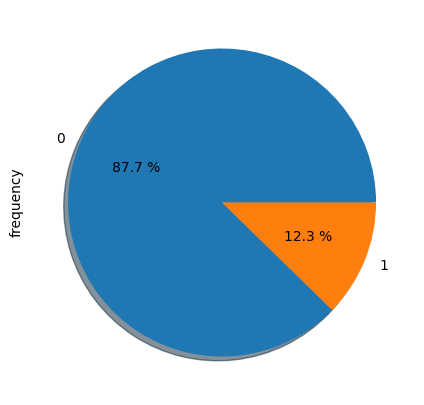

In [108]:
table = freq_tbl(dataClean['Risk_Flag'].astype("string"))
Filtro = table[table['frequency'] > 2]
Filtro_setter = Filtro.set_index("Risk_Flag")
Filtro_setter

Filtro_setter["frequency"].plot(kind="pie", figsize=(10,5), shadow=True, autopct="%0.1f %%")

print(f'Personas sin riesgo: {table["frequency"][0]}')
print(f'Personas en riesgo: {table["frequency"][1]}')